In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure
import topologika as ta

In [2]:
data = np.fromfile('../datasets/cosmology_256x256x256_float32.raw', dtype=np.float32).reshape(256, 256, 256)
forest = ta.MergeForest(data)

In [3]:
threshold = 15
persistence_threshold = 0.1*np.ptp(data) # TODO: should we use persistence [0, 1]? (then we need global computation to get data extent)

# Persistence Diagram

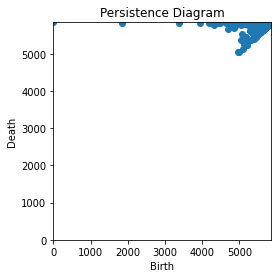

In [4]:
extent = np.min(data), np.max(data)

xs = []
ys = []
for maximum in ta.maxima(forest):
    p = ta.persistence(forest, maximum)
    if math.isinf(p):
        xs.append(extent[1] - data[maximum])
        ys.append(extent[1] - extent[0])
    else:
        xs.append(extent[1] - data[maximum])
        ys.append(extent[1] - (data[maximum] - p))

plt.title('Persistence Diagram')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.xlim(extent[0], extent[1])
plt.ylim(extent[0], extent[1])
plt.gca().set_aspect('equal')
plt.scatter(xs, ys);

# Persistence Curve

In [5]:
# TODO

# Persistence Simplification using Components Query

In [6]:
%%time
simplified_components = []
components = ta.components(forest, threshold)
for component in components:
    # TODO: support numpy int types in queries
    vertex = component[0][0].item(), component[1][0].item(), component[2][0].item()
    maximum = ta.componentmax(forest, vertex, threshold)
    if ta.persistence(forest, maximum) >= persistence_threshold:
        simplified_components.append(component)
        
print(len(components), len(simplified_components))

5025 15
Wall time: 834 ms


# Persistence Simplification using Component Query

An interesting experiment would be to run the for loop in parallel. Compared to the `components` query, this approach is easy to parallelize.

In [7]:
%%time
simplified_components = []
for maximum in ta.maxima(forest):
    m = ta.componentmax(forest, maximum, threshold)
    if m != maximum:
        continue
    if ta.persistence(forest, maximum) >= persistence_threshold:
        simplified_components.append(ta.component(forest, maximum, threshold))
        
print(len(components), len(simplified_components))

5025 15
Wall time: 1.34 s


# Visualization of Isosurface of Every Component

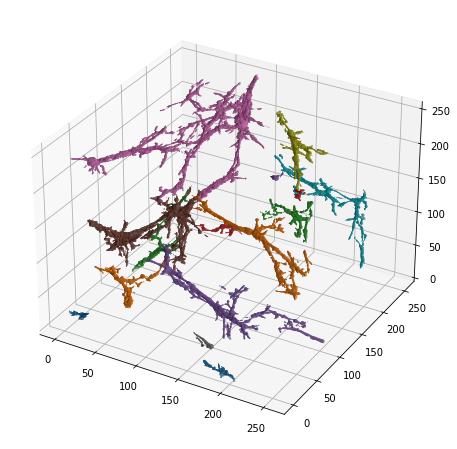

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for component in simplified_components:
    tmp = np.zeros(data.shape)
    tmp[component] = data[component]
    verts, faces, _, _ = skimage.measure.marching_cubes(tmp, threshold)
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
plt.show()